In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv('secom_data.csv')
df.head(5)
# Split into features and target
X = df.drop(columns=['Pass/Fail'])
y = df['Pass/Fail']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Remove columns with >50% missing values
missing_values_percent = X_train.isna().mean() * 100
columns_to_keep = missing_values_percent[missing_values_percent <= 50].index
X_train_filtered = X_train[columns_to_keep]
X_test_filtered = X_test[columns_to_keep]

# Remove zero variance columns
zero_variance_cols = X_train_filtered.columns[X_train_filtered.nunique() <= 1]
X_train_filtered = X_train_filtered.drop(columns=zero_variance_cols)
X_test_filtered = X_test_filtered.drop(columns=zero_variance_cols)


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

# Initialize the scaler and imputer
scaler = MinMaxScaler()
imputer = KNNImputer()

X_train_imputed = imputer.fit_transform(X_train_filtered)
X_test_imputed = imputer.transform(X_test_filtered)

X_train_imputed = pd.DataFrame(X_train_imputed, columns = X_train_filtered.columns)
X_test_imputed = pd.DataFrame(X_test_imputed, columns = X_test_filtered.columns)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
def outliers(df):
    features = df.columns
    for j in features:
        Q1 = df[j].quantile(q=0.25)
        Q2 = df[j].median()
        Q3 = df[j].quantile(q=0.75)
        IQR = Q3 - Q1
        upper_bound = Q3 + 1.5 * IQR
        lower_bound = Q1 - 1.5 * IQR
        for i in range(0, df.shape[0]):
            if df[j][i] > upper_bound or df[j][i] < lower_bound:
                df[j][i] = df[j].median()
    return df

# Handle outliers in the training set
train_features = outliers(X_train_imputed)

# Handle outliers in the testing set
test_features = outliers(X_test_imputed)

In [ ]:
X_train_scaled = scaler.fit_transform(train_features)
X_test_scaled = scaler.transform(test_features)

In [ ]:
X_train_data= pd.DataFrame(X_train_scaled, columns = X_train_imputed.columns)
X_test_data = pd.DataFrame(X_test_scaled, columns = X_test_imputed.columns)

In [ ]:
print(X_train_data.shape)
print(y_train.shape)
print(type(X_train_data))
print(type(y_train))


(1175, 450)
(1175,)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [ ]:
from boruta import BorutaPy
import numpy as np
from sklearn.ensemble import RandomForestClassifier


np.int = np.int32
np.float = np.float64
np.bool = np.bool_


X_train_data = pd.DataFrame(X_train_scaled, columns=X_train_imputed.columns)
X_test_data = pd.DataFrame(X_test_scaled, columns=X_test_imputed.columns)
y_train = y_train.astype(int)

rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5, random_state=42)
boruta = BorutaPy(rf, n_estimators='auto', random_state=42)
boruta.fit(X_train_data.values, y_train.values)
selected_features = X_train_data.columns[boruta.support_].tolist()
print("Selected Features:", selected_features)
X_train_selected = boruta.transform(X_train_scaled)
X_test_selected = boruta.transform(X_test_scaled)


Selected Features: ['Feature_34', 'Feature_60', 'Feature_79', 'Feature_104', 'Feature_131', 'Feature_206', 'Feature_214', 'Feature_332', 'Feature_352', 'Feature_418']


In [ ]:
from imblearn.over_sampling import BorderlineSMOTE, SMOTE

smote = SMOTE(random_state=42)
borderline_smote = BorderlineSMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)
X_train_borderline_smote, y_train_borderline_smote = borderline_smote.fit_resample(X_train_selected, y_train)


print("Training features shape after SMOTE:", X_train_smote.shape)
print("Training labels shape after SMOTE:", y_train_smote.shape)
print("Training features shape after BorderlineSMOTE:", X_train_borderline_smote.shape)
print("Training labels shape after BorderlineSMOTE:", y_train_borderline_smote.shape)



Training features shape after SMOTE: (2194, 10)
Training labels shape after SMOTE: (2194,)
Training features shape after BorderlineSMOTE: (2194, 10)
Training labels shape after BorderlineSMOTE: (2194,)


Results on SMOTE data:
Training and evaluating RandomForest
Confusion Matrix for RandomForest:
 [[349  17]
 [ 20   6]]
Classification Report for RandomForest:
               precision    recall  f1-score   support

          -1       0.95      0.95      0.95       366
           1       0.26      0.23      0.24        26

    accuracy                           0.91       392
   macro avg       0.60      0.59      0.60       392
weighted avg       0.90      0.91      0.90       392

ROC AUC for RandomForest: 0.6584
Training and evaluating DecisionTree
Confusion Matrix for DecisionTree:
 [[324  42]
 [ 19   7]]
Classification Report for DecisionTree:
               precision    recall  f1-score   support

          -1       0.94      0.89      0.91       366
           1       0.14      0.27      0.19        26

    accuracy                           0.84       392
   macro avg       0.54      0.58      0.55       392
weighted avg       0.89      0.84      0.87       392

ROC AUC for Deci

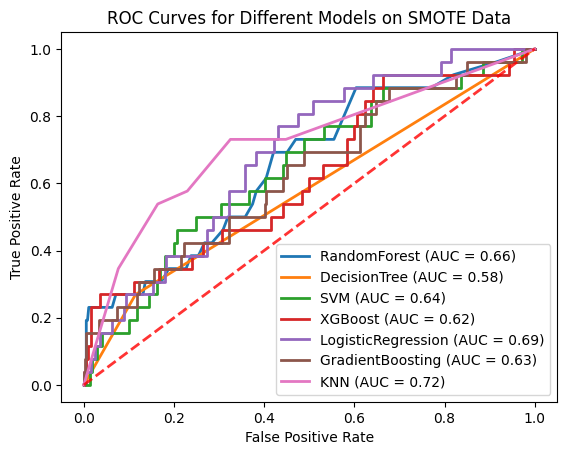

Results on BorderlineSMOTE data:
Training and evaluating RandomForest
Confusion Matrix for RandomForest:
 [[357   9]
 [ 20   6]]
Classification Report for RandomForest:
               precision    recall  f1-score   support

          -1       0.95      0.98      0.96       366
           1       0.40      0.23      0.29        26

    accuracy                           0.93       392
   macro avg       0.67      0.60      0.63       392
weighted avg       0.91      0.93      0.92       392

ROC AUC for RandomForest: 0.6506
Training and evaluating DecisionTree
Confusion Matrix for DecisionTree:
 [[331  35]
 [ 20   6]]
Classification Report for DecisionTree:
               precision    recall  f1-score   support

          -1       0.94      0.90      0.92       366
           1       0.15      0.23      0.18        26

    accuracy                           0.86       392
   macro avg       0.54      0.57      0.55       392
weighted avg       0.89      0.86      0.87       392

ROC AU

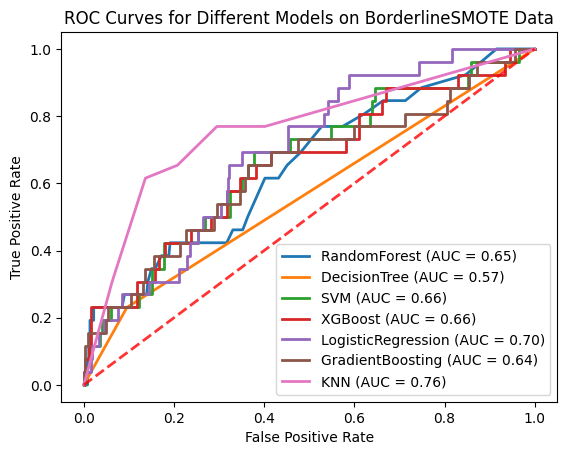

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Define models, including KNN
models = {
    "RandomForest": RandomForestClassifier(n_jobs=-1, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "KNN": KNeighborsClassifier()
}

def convert_labels(labels):
    return labels.replace({-1: 0, 1: 1}) #this was necessary because classifiers like SVM, XGBoost only accept binary values, that is 0 amd 1

def convert_predictions(predictions):
    return [-1 if pred == 0 else 1 for pred in predictions]

def train_and_evaluate(models, X_train, y_train, X_test, y_test):
    y_train_converted = convert_labels(y_train)
    y_test_converted = convert_labels(y_test)

    for model_name, model in models.items():
        print(f"Training and evaluating {model_name}")
        model.fit(X_train, y_train_converted)
        y_pred_converted = model.predict(X_test)
        y_pred = convert_predictions(y_pred_converted)

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())  # [0,1] for SVM and XGB, explain deets

        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion Matrix for {model_name}:\n", cm)

        classification_report_str = classification_report(y_test, y_pred)
        print(f"Classification Report for {model_name}:\n", classification_report_str)

        roc_auc = roc_auc_score(y_test_converted, y_proba)
        print(f"ROC AUC for {model_name}: {roc_auc:.4f}")

        fpr, tpr, _ = roc_curve(y_test_converted, y_proba)
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

print("Results on SMOTE data:")
train_and_evaluate(models, X_train_smote, y_train_smote, X_test_selected, y_test)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models on SMOTE Data')
plt.legend(loc='lower right')
plt.show()

print("Results on BorderlineSMOTE data:")
train_and_evaluate(models, X_train_borderline_smote, y_train_borderline_smote, X_test_selected, y_test)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=.8)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different Models on BorderlineSMOTE Data')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, roc_auc_score
import pandas as pd
import numpy as np

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    return TN / (TN + FP)

def g_mean_score(sensitivity, specificity):
    return np.sqrt(sensitivity * specificity)

def calculate_cost(y_true, y_pred, cost_fp=20, cost_fn=60):
    cm = confusion_matrix(y_true, y_pred)
    FP = cm[0, 1]
    FN = cm[1, 0]
    return (cost_fp * FP) + (cost_fn * FN)

def convert_labels(labels):
    return labels.replace({-1: 0, 1: 1})

def convert_predictions(predictions):
    return [-1 if pred == 0 else 1 for pred in predictions]

def print_kpis_table(models, X_train, y_train, X_test, y_test, cost_fp=20, cost_fn=60):
    y_train_converted = convert_labels(y_train)
    y_test_converted = convert_labels(y_test)

    kpis = []

    for model_name, model in models.items():
        model.fit(X_train, y_train_converted)
        y_pred_converted = model.predict(X_test)
        y_pred = convert_predictions(y_pred_converted)

        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)
            y_proba = (y_proba - y_proba.min()) / (y_proba.max() - y_proba.min())
        sensitivity = recall_score(y_test, y_pred)
        specificity = specificity_score(y_test, y_pred)
        g_means = g_mean_score(sensitivity, specificity)
        auc = roc_auc_score(y_test_converted, y_proba)
        cost = calculate_cost(y_test, y_pred, cost_fp=cost_fp, cost_fn=cost_fn)

        kpis.append({
            "Model": model_name,
            "Sensitivity (Recall)": sensitivity,
            "Specificity": specificity,
            "G-means": g_means,
            "AUC": auc,
            "Cost ": cost
        })

    kpis_df = pd.DataFrame(kpis)
    print(kpis_df)

print("KPIs for SMOTE data:")
print_kpis_table(models, X_train_smote, y_train_smote, X_test_selected, y_test, cost_fp=20, cost_fn=60)

print("\nKPIs for BorderlineSMOTE data:")
print_kpis_table(models, X_train_borderline_smote, y_train_borderline_smote, X_test_selected, y_test, cost_fp=20, cost_fn=60)


KPIs for SMOTE data:
                Model  Sensitivity (Recall)  Specificity   G-means       AUC  \
0        RandomForest              0.230769     0.953552  0.469095  0.658365   
1        DecisionTree              0.269231     0.885246  0.488196  0.577238   
2                 SVM              0.461538     0.756831  0.591022  0.644283   
3             XGBoost              0.269231     0.918033  0.497155  0.624632   
4  LogisticRegression              0.576923     0.658470  0.616349  0.689365   
5    GradientBoosting              0.346154     0.838798  0.538844  0.630202   
6                 KNN              0.576923     0.770492  0.666719  0.718474   

   Cost   
0   1540  
1   1980  
2   2620  
3   1740  
4   3160  
5   2200  
6   2340  

KPIs for BorderlineSMOTE data:
                Model  Sensitivity (Recall)  Specificity   G-means       AUC  \
0        RandomForest              0.230769     0.975410  0.474441  0.650641   
1        DecisionTree              0.230769     0.904372  

In [ ]:
models_finalised = {
    "GradientBoosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "KNN": KNeighborsClassifier()
}

In [ ]:
from sklearn.impute import KNNImputer, SimpleImputer

imputations = {
    'mean_impute': SimpleImputer(strategy='mean'),
    'median_impute': SimpleImputer(strategy='median'),
    'knn_impute': KNNImputer()
}


In [ ]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score

models = {
    'SVM': SVC(probability=True, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

samplers = {
    'SMOTE': SMOTE(random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42)
}

results = {}
for model_name, model in models.items():
    for imp_name, imputer in imputations.items():
        for samp_name, sampler in samplers.items():
            pipeline = IMBPipeline([
                ('imputer', imputer),
                ('scaler', MinMaxScaler()),  #data is scaled, especially for SVM and KNN
                ('sampler', sampler),
                ('classifier', model)
            ])
            param_grid = {}
            grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
            grid_search.fit(X_test_selected, y_test)
            key = f"{model_name} with {imp_name} and {samp_name}"
            results[key] = grid_search.best_score_
            print(f"Best ROC AUC for {key}: {grid_search.best_score_}")


Best ROC AUC for SVM with mean_impute and SMOTE: 0.5623423423423424
Best ROC AUC for SVM with mean_impute and BorderlineSMOTE: 0.6042922374429224
Best ROC AUC for SVM with mean_impute and ADASYN: 0.5698309268172281
Best ROC AUC for SVM with median_impute and SMOTE: 0.5623423423423424
Best ROC AUC for SVM with median_impute and BorderlineSMOTE: 0.6042922374429224
Best ROC AUC for SVM with median_impute and ADASYN: 0.5698309268172281
Best ROC AUC for SVM with knn_impute and SMOTE: 0.5623423423423424
Best ROC AUC for SVM with knn_impute and BorderlineSMOTE: 0.6042922374429224
Best ROC AUC for SVM with knn_impute and ADASYN: 0.5698309268172281
Best ROC AUC for LogisticRegression with mean_impute and SMOTE: 0.623761569788967
Best ROC AUC for LogisticRegression with mean_impute and BorderlineSMOTE: 0.6335727508330249
Best ROC AUC for LogisticRegression with mean_impute and ADASYN: 0.6247340491176108
Best ROC AUC for LogisticRegression with median_impute and SMOTE: 0.623761569788967
Best ROC 

Best ROC AUC for SVM with mean_impute and SMOTE: 0.6409774157719363
Best parameters for SVM with mean_impute and SMOTE: {'classifier__C': 10, 'classifier__kernel': 'linear'}
Best ROC AUC for SVM with mean_impute and BorderlineSMOTE: 0.6485499197827964
Best parameters for SVM with mean_impute and BorderlineSMOTE: {'classifier__C': 10, 'classifier__kernel': 'linear'}
Best ROC AUC for SVM with mean_impute and ADASYN: 0.6446822164630384
Best parameters for SVM with mean_impute and ADASYN: {'classifier__C': 10, 'classifier__kernel': 'linear'}
Best ROC AUC for SVM with median_impute and SMOTE: 0.6409774157719363
Best parameters for SVM with median_impute and SMOTE: {'classifier__C': 10, 'classifier__kernel': 'linear'}
Best ROC AUC for SVM with median_impute and BorderlineSMOTE: 0.6485499197827964
Best parameters for SVM with median_impute and BorderlineSMOTE: {'classifier__C': 10, 'classifier__kernel': 'linear'}
Best ROC AUC for SVM with median_impute and ADASYN: 0.6446822164630384
Best para

<Figure size 1000x800 with 0 Axes>

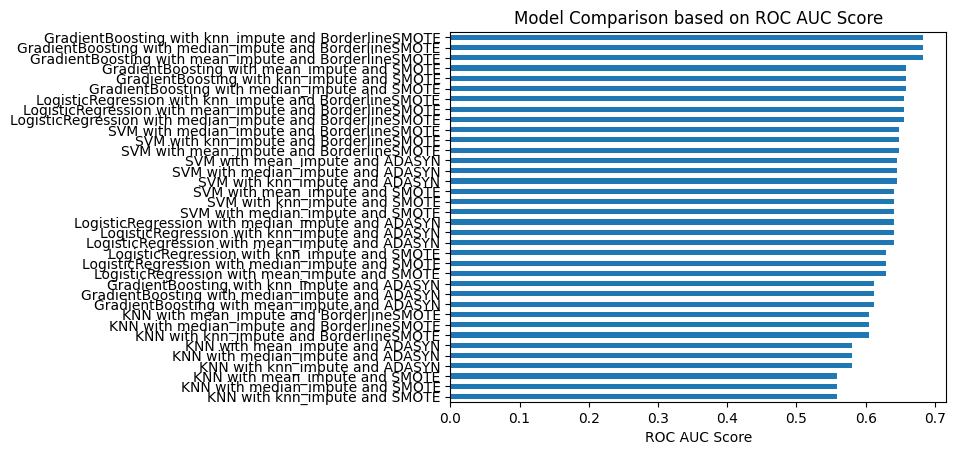

In [ ]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline as IMBPipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

# Define models
models = {
    'SVM': SVC(probability=True, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'KNN': KNeighborsClassifier()
}

# Define imputations
imputations = {
    'mean_impute': SimpleImputer(strategy='mean'),
    'median_impute': SimpleImputer(strategy='median'),
    'knn_impute': KNNImputer()
}

# Define samplers
samplers = {
    'SMOTE': SMOTE(random_state=42),
    'BorderlineSMOTE': BorderlineSMOTE(random_state=42),
    'ADASYN': ADASYN(random_state=42)
}

# Define parameter grids for GridSearchCV
param_grids = {
    'SVM': {
        'classifier__C': [0.1, 1, 10],
        'classifier__kernel': ['linear', 'rbf']
    },
    'LogisticRegression': {
        'classifier__C': [0.1, 1, 10],
        'classifier__solver': ['liblinear', 'lbfgs']
    },
    'GradientBoosting': {
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate': [0.01, 0.1],
        'classifier__max_depth': [3, 5]
    },
    'KNN': {
        'classifier__n_neighbors': [3, 5, 7],
        'classifier__weights': ['uniform', 'distance']
    }
}

results = {}
best_params = {}

for model_name, model in models.items():
    for imp_name, imputer in imputations.items():
        for samp_name, sampler in samplers.items():
            pipeline = IMBPipeline([
                ('imputer', imputer),
                ('scaler', MinMaxScaler()),  # Data is scaled, especially for SVM and KNN
                ('sampler', sampler),
                ('classifier', model)
            ])
            param_grid = param_grids[model_name]
            grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
            grid_search.fit(X_test_selected, y_test)
            key = f"{model_name} with {imp_name} and {samp_name}"
            results[key] = grid_search.best_score_
            best_params[key] = grid_search.best_params_
            print(f"Best ROC AUC for {key}: {grid_search.best_score_}")
            print(f"Best parameters for {key}: {grid_search.best_params_}")


results_df = pd.DataFrame.from_dict(results, orient='index', columns=['ROC AUC Score'])
sorted_results_df = results_df.sort_values(by='ROC AUC Score', ascending=False)


print("Ranked Models based on ROC AUC Score:")
print(sorted_results_df)
plt.figure(figsize=(10, 8))
sorted_results_df.plot(kind='barh', legend=False)
plt.xlabel('ROC AUC Score')
plt.title('Model Comparison based on ROC AUC Score')
plt.gca().invert_yaxis()
plt.show()


In [ ]:
param_grid = {
    "KNN": {
        'imputer__n_neighbors': [3, 5, 7],
        'smote__k_neighbors': [3, 5, 7],
        'model__n_neighbors': [5, 10, 15],
    },
    "LogisticRegression": {
        'imputer__n_neighbors': [3, 5, 7],
        'smote__k_neighbors': [3, 5, 7],
        'model__C': [0.01, 0.1, 1, 10]
    },
    "SVM": {
        'imputer__n_neighbors': [3, 5, 7],
        'smote__k_neighbors': [3, 5, 7],
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf']
    },
    "GradientBoosting": {
        'imputer__n_neighbors': [3, 5, 7],
        'smote__k_neighbors': [3, 5, 7],
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    }
}

for model_name, model in models.items():
    pipeline = ImbPipeline([
        ('imputer', KNNImputer()),
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    grid_search = GridSearchCV(pipeline, param_grid[model_name], cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)
    grid_search.fit(X_train_selected, y_train)
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {model_name}: {grid_search.best_score_:.2f}")

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters for SVM: {'imputer__n_neighbors': 3, 'model__C': 0.1, 'model__kernel': 'linear', 'smote__k_neighbors': 3}
Best cross-validation score for SVM: 0.74
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters for LogisticRegression: {'imputer__n_neighbors': 3, 'model__C': 0.01, 'smote__k_neighbors': 3}
Best cross-validation score for LogisticRegression: 0.75
Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best parameters for GradientBoosting: {'imputer__n_neighbors': 3, 'model__learning_rate': 0.01, 'model__max_depth': 5, 'model__n_estimators': 100, 'smote__k_neighbors': 3}
Best cross-validation score for GradientBoosting: 0.75
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for KNN: {'imputer__n_neighbors': 3, 'model__n_neighbors': 15, 'smote__k_neighbors': 3}
Best cross-validation score for KNN: 0.71


Step1: Try fitting all the models with the overall best imputer and best sampling method

In [ ]:
from sklearn.metrics import classification_report


best_combination = sorted_results_df.index[0]
best_imputer = best_combination.split(" with ")[1].split(" and ")[0]
best_sampler = best_combination.split(" and ")[1]

print(f"Best Imputer: {best_imputer}")
print(f"Best Sampler: {best_sampler}")
best_imputer_instance = imputations[best_imputer]
best_sampler_instance = samplers[best_sampler]

for model_name, model in models.items():
    print(f"\nTesting model: {model_name} with {best_imputer} and {best_sampler}")

    pipeline = IMBPipeline([
        ('imputer', best_imputer_instance),
        ('scaler', MinMaxScaler()),  # Data is scaled, especially for SVM and KNN
        ('sampler', best_sampler_instance),
        ('classifier', model)
    ])


    param_grid = param_grids[model_name]


    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc')
    grid_search.fit(X_train_selected, y_train)
    y_pred = grid_search.predict(X_test_selected)
    report = classification_report(y_test, y_pred)
    print(f"Classification Report for {model_name} with {best_imputer} and {best_sampler}:\n{report}")


Best Imputer: knn_impute
Best Sampler: BorderlineSMOTE

Testing model: SVM with knn_impute and BorderlineSMOTE
Classification Report for SVM with knn_impute and BorderlineSMOTE:
              precision    recall  f1-score   support

          -1       0.95      0.71      0.81       366
           1       0.09      0.42      0.15        26

    accuracy                           0.69       392
   macro avg       0.52      0.57      0.48       392
weighted avg       0.89      0.69      0.77       392


Testing model: LogisticRegression with knn_impute and BorderlineSMOTE
Classification Report for LogisticRegression with knn_impute and BorderlineSMOTE:
              precision    recall  f1-score   support

          -1       0.95      0.72      0.82       366
           1       0.10      0.46      0.17        26

    accuracy                           0.70       392
   macro avg       0.53      0.59      0.49       392
weighted avg       0.89      0.70      0.78       392


Testing model:

In [ ]:
from imblearn.pipeline import Pipeline as ImbPipeline

imputer = KNNImputer(n_neighbors=3)
imputer2 = SimpleImputer(strategy = 'median')
smote = SMOTE(k_neighbors=5)

models_finalised = {
    "KNN": KNeighborsClassifier(n_neighbors=10),
    "LogisticRegression": LogisticRegression(C=10),
    "SVM": SVC(C=0.1, kernel='rbf', probability=True),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, max_depth=3)
}

pipelines = {
    "KNN": ImbPipeline([('imputer', KNNImputer(n_neighbors=3)), ('scaler', MinMaxScaler()), ('smote', SMOTE(k_neighbors=5)), ('model', models["KNN"])]),
    "LogisticRegression": ImbPipeline([('imputer', KNNImputer(n_neighbors=3)), ('scaler', MinMaxScaler()), ('smote', SMOTE(k_neighbors=7)), ('model', models["LogisticRegression"])]),
    "SVM": ImbPipeline([('imputer2', SimpleImputer(strategy= 'median')), ('scaler', MinMaxScaler()), ('smote', SMOTE(k_neighbors=7)), ('model', models["SVM"])]),
    "GradientBoosting": ImbPipeline([('imputer', KNNImputer(n_neighbors=7)), ('smote', BorderlineSMOTE(k_neighbors=3)), ('model', models["GradientBoosting"])])
}


In [ ]:
for name, pipeline in pipelines.items():
    pipeline.fit(X_train_selected, y_train)
    y_pred = pipeline.predict(X_test_selected)
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))

Classification Report for KNN:
              precision    recall  f1-score   support

          -1       0.97      0.72      0.83       366
           1       0.14      0.65      0.23        26

    accuracy                           0.72       392
   macro avg       0.55      0.69      0.53       392
weighted avg       0.91      0.72      0.79       392

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

          -1       0.95      0.66      0.78       366
           1       0.09      0.46      0.15        26

    accuracy                           0.65       392
   macro avg       0.52      0.56      0.46       392
weighted avg       0.89      0.65      0.74       392

Classification Report for SVM:
              precision    recall  f1-score   support

          -1       0.96      0.65      0.78       366
           1       0.11      0.62      0.19        26

    accuracy                           0.65       392
   macro avg       0

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cost_fp = 20
cost_fn = 60

for name, pipeline in pipelines.items():
    pipeline.fit(X_train_selected, y_train)
    y_pred = pipeline.predict(X_test_selected)
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion Matrix for {name}:\n{cm}")

    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    Sensitivity = TP / (TP + FN)
    print(f"Sensitivity (Recall) for {name}: {Sensitivity:.2f}")
    Specificity = TN / (TN + FP)
    print(f"Specificity for {name}: {Specificity:.2f}")
    Precision = TP / (TP + FP)
    print(f"Precision for {name}: {Precision:.2f}")
    Fall_out = FP / (FP + TN)
    print(f"False Positive Rate for {name}: {Fall_out:.2f}")
    False_Negative_Rate = FN / (FN + TP)
    print(f"False Negative Rate for {name}: {False_Negative_Rate:.2f}")
    total_cost = (FP * cost_fp) + (FN * cost_fn)
    print(f"Total Cost of Miscalculation for {name}: €{total_cost:.2f}\n")


Classification Report for KNN:
              precision    recall  f1-score   support

          -1       0.97      0.72      0.83       366
           1       0.14      0.65      0.24        26

    accuracy                           0.72       392
   macro avg       0.56      0.69      0.53       392
weighted avg       0.91      0.72      0.79       392

Confusion Matrix for KNN:
[[265 101]
 [  9  17]]
Sensitivity (Recall) for KNN: 0.65
Specificity for KNN: 0.72
Precision for KNN: 0.14
False Positive Rate for KNN: 0.28
False Negative Rate for KNN: 0.35
Total Cost of Miscalculation for KNN: €2560.00

Classification Report for LogisticRegression:
              precision    recall  f1-score   support

          -1       0.95      0.67      0.79       366
           1       0.09      0.46      0.15        26

    accuracy                           0.66       392
   macro avg       0.52      0.57      0.47       392
weighted avg       0.89      0.66      0.75       392

Confusion Matrix fo

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report


if not isinstance(X_train_selected, pd.DataFrame):
    X_train_selected = pd.DataFrame(X_train_selected)
if not isinstance(y_train, pd.Series):
    y_train = pd.Series(y_train)

# Costs for misclassifications assumed, cost of False Negatives are taken to be higher
cost_fp = 20
cost_fn = 60
models_to_compare = {
    "SVM": models["SVM"],
    "KNN": models["KNN"]
}

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
def evaluate_model_with_kfold(name, pipeline, X, y, kf):
    fold = 1
    for train_index, test_index in kf.split(X):
        print(f"Processing fold {fold} for {name}...")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        TN, FP, FN, TP = cm.ravel()
        Sensitivity = TP / (TP + FN)
        Specificity = TN / (TN + FP)
        Precision = TP / (TP + FP)
        Fall_out = FP / (FP + TN)
        False_Negative_Rate = FN / (FN + TP)
        total_cost = (FP * cost_fp) + (FN * cost_fn)

        print(f"Fold {fold} - Confusion Matrix:\n{cm}")
        print(f"Fold {fold} - Sensitivity (Recall): {Sensitivity:.2f}")
        print(f"Fold {fold} - Specificity: {Specificity:.2f}")
        print(f"Fold {fold} - Precision: {Precision:.2f}")
        print(f"Fold {fold} - False Positive Rate: {Fall_out:.2f}")
        print(f"Fold {fold} - False Negative Rate: {False_Negative_Rate:.2f}")
        print(f"Fold {fold} - Total Cost of Miscalculation: €{total_cost:.2f}\n")

        fold += 1

for model_name in models_to_compare.keys():
    model_results = {k: v for k, v in results.items() if model_name in k}
    best_combination = max(model_results, key=model_results.get)
    best_imputer = best_combination.split(" with ")[1].split(" and ")[0]
    best_sampler = best_combination.split(" and ")[1]
    best_imputer_instance = imputations[best_imputer]
    best_sampler_instance = samplers[best_sampler]
    model = models[model_name]

    pipeline = IMBPipeline([
        ('imputer', best_imputer_instance),
        ('scaler', MinMaxScaler()),
        ('sampler', best_sampler_instance),
        ('classifier', model)
    ])
    best_model_params = best_params[best_combination]
    pipeline.set_params(**{f'classifier__{k.split("__")[1]}': v for k, v in best_model_params.items()})
    evaluate_model_with_kfold(model_name, pipeline, X_train_selected, y_train, kf)


Processing fold 1 for SVM...
Fold 1 - Confusion Matrix:
[[145  77]
 [  9   4]]
Fold 1 - Sensitivity (Recall): 0.31
Fold 1 - Specificity: 0.65
Fold 1 - Precision: 0.05
Fold 1 - False Positive Rate: 0.35
Fold 1 - False Negative Rate: 0.69
Fold 1 - Total Cost of Miscalculation: €2080.00

Processing fold 2 for SVM...
Fold 2 - Confusion Matrix:
[[138  79]
 [  4  14]]
Fold 2 - Sensitivity (Recall): 0.78
Fold 2 - Specificity: 0.64
Fold 2 - Precision: 0.15
Fold 2 - False Positive Rate: 0.36
Fold 2 - False Negative Rate: 0.22
Fold 2 - Total Cost of Miscalculation: €1820.00

Processing fold 3 for SVM...
Fold 3 - Confusion Matrix:
[[134  81]
 [  6  14]]
Fold 3 - Sensitivity (Recall): 0.70
Fold 3 - Specificity: 0.62
Fold 3 - Precision: 0.15
Fold 3 - False Positive Rate: 0.38
Fold 3 - False Negative Rate: 0.30
Fold 3 - Total Cost of Miscalculation: €1980.00

Processing fold 4 for SVM...
Fold 4 - Confusion Matrix:
[[159  63]
 [  5   8]]
Fold 4 - Sensitivity (Recall): 0.62
Fold 4 - Specificity: 0.72
